# Convergence study

For a given campaign load models for all available freqs and plot
convergence, duration ...


In [1]:
# Reload automatically all python modules before each cell exec
%load_ext autoreload
%autoreload 2

In [2]:
# standard python packages
import sys
import time
import os
import pickle
import numpy as np
from model_tools import load_model
# visu
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import scipy.io
import h5py
import simulation_campaigns
import collections
from post_process import compute_errors, plot_campaign, check_time_vectors, plot_errors, plot_y, plot_durations
import datetime

## Pick up results file(s)

Campaign parameters are supposed to be saved in a 'pkl' file

Load it and get sets of results (one set = a model run for different values of frequency)

#### List pkl files available:

In [4]:
ls campaign*.pkl

campaign0212.pkl       campaign_new_0612.pkl


#### Load a pkl and print configs and freqs

In [5]:
import pickle
import subprocess
pklfilename = 'campaign0212.pkl'
figures_path = 'fig_' + os.path.splitext(pklfilename)[0]
if not os.path.exists(figures_path):
    os.mkdir(figures_path)
#pkl_file = open('campaign_new_0612.pkl', 'rb')
pkl_file = open(pklfilename, 'rb')

remote_data = pickle.load(pkl_file)
for name in remote_data:
    print("Campaign name : " + name)
    if name.find('results') < 0:
        print("Available freqs:")
        print(list(remote_data[name].keys()))
        print("\n")


Campaign name : bass_guitar_0.0
Available freqs:
['31360', '15680', '2007040', '62720', '125440', '250880', '1003520', '4014080', '501760', '8028160', '16056320', '32112640', '64225280']


Campaign name : results_paths
Campaign name : bass_guitar_0.9
Available freqs:
['15680', '8028160', '4014080', '62720', '2007040', '31360', '501760', '1003520', '32112640', '16056320', '125440', '250880', '64225280']


Campaign name : bass_guitar_1.0
Available freqs:
['15680', '62720', '501760', '16056320', '31360', '4014080', '125440', '250880', '1003520', '2007040', '32112640', '8028160', '64225280']


Campaign name : fretless_guitar_0.0
Available freqs:
['31360', '15680', '62720']


Campaign name : fretless_guitar_0.9
Available freqs:
['15680', '31360']


Campaign name : fretless_guitar_1.0
Available freqs:
['15680', '31360']




## Convergence study

In [6]:
matlab_frets = './bass_guitar/pb2'
matlab_fretless = './fretless_bass_guitar/bsf'
errors = {}
freqs = {}
ymin = {}
timers = {}

In [7]:
names = [name for name in remote_data.keys() if name.find('bass') >=0]
#names=['bass_new_1.0']

for name in names:
    campaign = remote_data[name]
    if name.find('new') >=0 : 
        shift = 2
    else:
        shift=1
    fileslist = {}
    results_path = remote_data["results_paths"][1]
    timers[name] = np.zeros((len(campaign), 3))
    j = 0
    for freq in campaign:
        fileslist[np.float(freq)] = os.path.join(results_path, campaign[freq][5])
        timers[name][j, :] = [np.float(freq), np.float(campaign[freq][1]), np.int(campaign[freq][2])]
        j += 1                   
    fileslist = collections.OrderedDict(sorted(fileslist.items()))
    #print(fileslist)
    #check_time_vectors(filelist, matlab_frets)
    errors[name], ymin[name], freqs[name] = compute_errors(fileslist, indices=[9, 399, 799], from_matlab=matlab_frets,
                                                            shift=shift)

Load model from file ./Results_bass_0212/F_64225280_id_3879120/converted_g_862_64225280.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 64225280.0.
Save output every 4096 time steps.
Load model from file ./Results_bass_0212/F_15680_id_3879108/converted_g_862_15680.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 15680.0.
Save output every 1 time steps.
Load model from file ./Results_bass_0212/F_31360_id_3879109/converted_g_862_31360.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 31360.0.
Save output every 2 time steps.
Load model

Load model from file ./Results_bass_0212/F_32112640_id_3879132/converted_g_862_32112640.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 32112640.0.
Save output every 2048 time steps.
Load model from file ./Results_bass_0212/F_64225280_id_3879146/converted_g_862_64225280.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 64225280.0.
Save output every 4096 time steps.
Load model from file ./Results_bass_0212/F_15680_id_3879134/converted_g_862_15680.h5
Read data from files :
- neck profile:./bass_guitar/pb2_h.mat
- eigenfrequencies: ./bass_guitar/pb2_frequs.mat
- damping: ./bass_guitar/pb2_amortissements.mat

Ready to start simulation for frequency 15680.0.
Save output every 1 time steps

In [8]:
errors

{'bass_guitar_0.0': array([[ 2.50100779,  1.00285515,  1.39641169],
        [ 1.43306962,  1.02731089,  1.36090961],
        [ 0.78690602,  0.3700512 ,  0.4856698 ],
        [ 0.56385858,  0.21429409,  0.29288943],
        [ 0.96009171,  0.80194066,  0.86526559],
        [ 1.17387088,  1.18879624,  1.30237426],
        [ 0.12323478,  0.06741467,  0.09653668],
        [ 0.12686745,  0.06585327,  0.09737812],
        [ 0.08977195,  0.04406474,  0.06788376],
        [ 0.03114949,  0.01186057,  0.02053956],
        [ 0.06131636,  0.03043937,  0.0477549 ],
        [ 0.08497403,  0.04372801,  0.06717186]]),
 'bass_guitar_0.9': array([[ 5.57270576,  2.24804682,  2.38990709],
        [ 1.82361741,  2.79605951,  1.78777484],
        [ 1.70314903,  2.87495656,  1.87906413],
        [ 1.75070605,  2.67677279,  1.854907  ],
        [ 1.37129579,  1.49577732,  1.45875394],
        [ 0.58549013,  0.27164557,  0.39805928],
        [ 0.54952273,  0.25823272,  0.43795104],
        [ 1.1927336 ,  1.1781

### Plot convergence for bass guitar

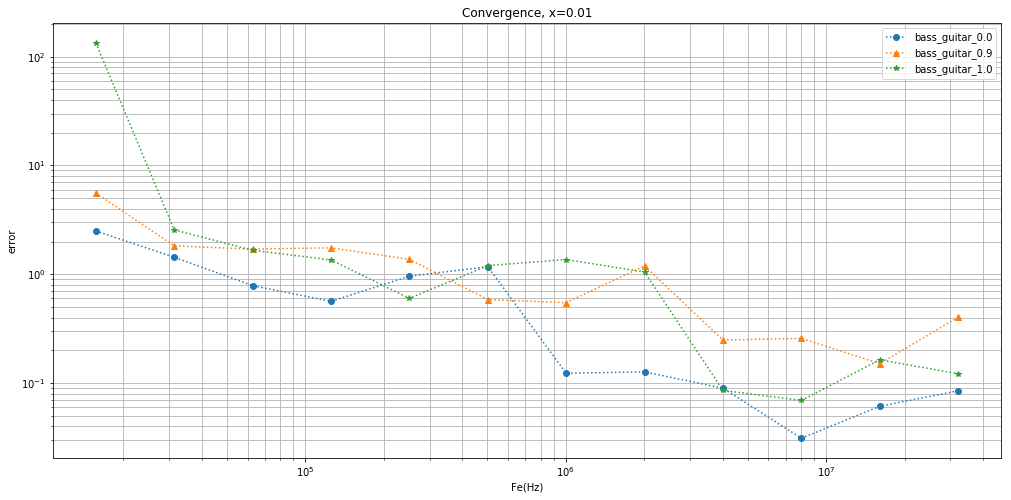

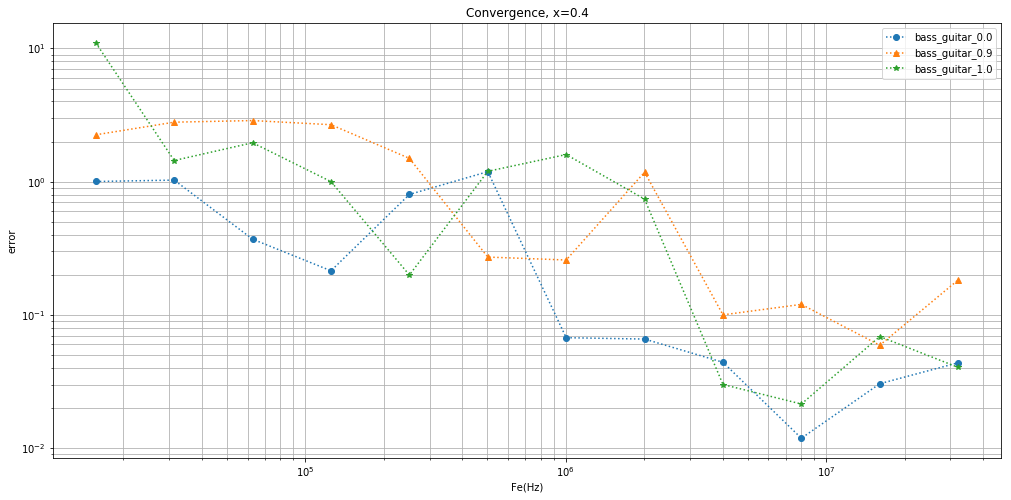

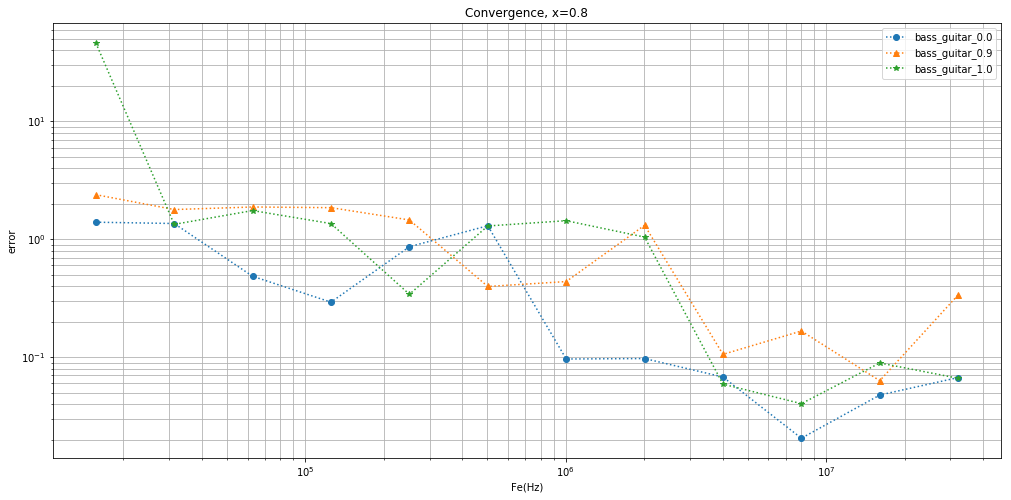

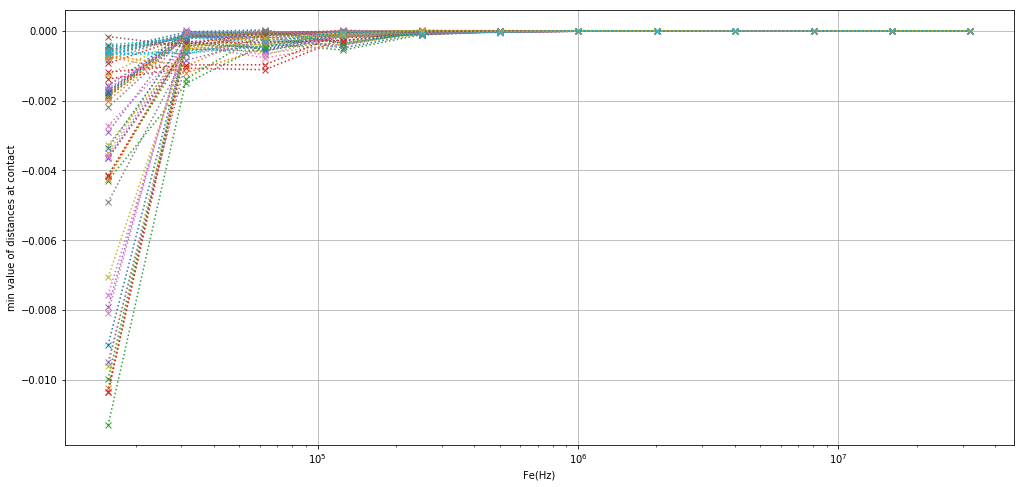

In [9]:
fig = plot_errors(errors, freqs, 0, 23)
fig.title("Convergence, x=0.01")
plt.savefig(os.path.join(figures_path, 'cvg_x=0.01.pdf'))
fig1 = plot_errors(errors, freqs, 1, 1)
fig1.title("Convergence, x=0.4")  
plt.savefig(os.path.join(figures_path, 'cvg_x=0.4.pdf'))
fig2 = plot_errors(errors, freqs, 2, 2)
fig2.title("Convergence, x=0.8")  
plt.savefig(os.path.join(figures_path, 'cvg_x=0.8.pdf'))
fig4 = plot_y(ymin, freqs, 4)
#fig4.title()
plt.savefig(os.path.join(figures_path, 'min_y.pdf'))

#### Save results (errors ...) in pkl file

In [10]:
date = datetime.datetime.now().isoformat()
bckpfilename = os.path.join(figures_path, 'backup' + str(date) + '.pkl')
print('backup to file ' + bckpfilename + ' ...')
bckpfile = open(bckpfilename, 'wb')
backups = (errors, ymin, freqs)
pickle.dump(backups, bckpfile)


backup to file fig_campaign0212/backup2017-12-13T14:26:26.296423.pkl ...


In [ ]:
# To load a file:
bckpfile = open('fig_campaign0212/cvg_with_ts/backup2017-12-13T14:21:19.269306.pkl', 'rb')
results = pickle.load(bckpfile)
err = results[0]
bckpfile.close()

### plot simulations durations

In [ ]:
fig = plot_durations(timers)
plt.savefig(os.path.join(figures_path, 'Durations.pdf'))